# VGG Model with 3 cases

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy

In [2]:
# Data transformations with enhanced augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = '../data/chest_xray'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Count class distribution
class_counts = {}
for phase in ['train', 'val', 'test']:
    class_counts[phase] = {class_name: 0 for class_name in class_names}
    dataset = image_datasets[phase]
    for _, label in dataset.samples:
        class_name = class_names[label]
        class_counts[phase][class_name] += 1

for phase in ['train', 'val', 'test']:
    print(f"\nClass counts in {phase}:")
    for class_name, count in class_counts[phase].items():
        print(f"{class_name}: {count}")


Class counts in train:
NORMAL: 2684
PNEUMONIA_BACTERIA: 2530
PNEUMONIA_VIRUS: 2690

Class counts in val:
NORMAL: 8
PNEUMONIA_BACTERIA: 8
PNEUMONIA_VIRUS: 3

Class counts in test:
NORMAL: 234
PNEUMONIA_BACTERIA: 242
PNEUMONIA_VIRUS: 148


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Load pre-trained VGG-16 model
model = models.vgg16_bn(pretrained=True)

# Freeze all layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last few layers for fine-tuning
for param in model.features[-10:].parameters():
    param.requires_grad = True

# Modify the classifier with dropout and for 3-class classification
num_features = model.classifier[6].in_features
model.classifier = nn.Sequential(
    *list(model.classifier.children())[:-1],  # All layers except the last one
    nn.Dropout(0.5),                         # Add dropout layer
    nn.Linear(num_features, 3)               # New layer for 3 classes
)

model = model.to(device)

# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower initial learning rate for fine-tuning
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/home/calviet/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/calviet/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/calviet/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# Training function with early stopping and model checkpointing
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Adjust learning rate if in validation phase
            if phase == 'val':
                scheduler.step(epoch_loss)

                # Update best model weights and early stopping counter
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0  # Reset early stopping counter
                else:
                    epochs_no_improve += 1

                # Early stopping check
                if epochs_no_improve == patience:
                    print("Early stopping due to no improvement")
                    model.load_state_dict(best_model_wts)
                    return model

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print('Training complete')
    return model

# Testing function with confusion matrix
def test_model(model):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_acc:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Save the best model function
def save_model(model, path='vgg16_pneumonia_3class.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved as {path}")

In [8]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.5366 Acc: 0.7575
val Loss: 1.1526 Acc: 0.4211
Epoch 2/20
----------
train Loss: 0.4177 Acc: 0.8121
val Loss: 1.1928 Acc: 0.3684
Epoch 3/20
----------
train Loss: 0.3856 Acc: 0.8335
val Loss: 1.3360 Acc: 0.3684
Epoch 4/20
----------
train Loss: 0.3547 Acc: 0.8454
val Loss: 0.5600 Acc: 0.6316
Epoch 5/20
----------
train Loss: 0.3307 Acc: 0.8599
val Loss: 1.1092 Acc: 0.4737
Epoch 6/20
----------
train Loss: 0.2986 Acc: 0.8726
val Loss: 1.0296 Acc: 0.4211
Epoch 7/20
----------
train Loss: 0.2774 Acc: 0.8825
val Loss: 0.6487 Acc: 0.6842
Epoch 8/20
----------
train Loss: 0.2654 Acc: 0.8875
val Loss: 0.7490 Acc: 0.7368
Epoch 9/20
----------
train Loss: 0.2179 Acc: 0.9111
val Loss: 0.8964 Acc: 0.6316
Epoch 10/20
----------
train Loss: 0.1935 Acc: 0.9236
val Loss: 1.0355 Acc: 0.6316
Epoch 11/20
----------
train Loss: 0.1840 Acc: 0.9278
val Loss: 1.0021 Acc: 0.6316
Epoch 12/20
----------
train Loss: 0.1723 Acc: 0.9291
val Loss: 1.0429 Acc: 0.6842
Epoch 13/20
-

Test Accuracy: 0.8429


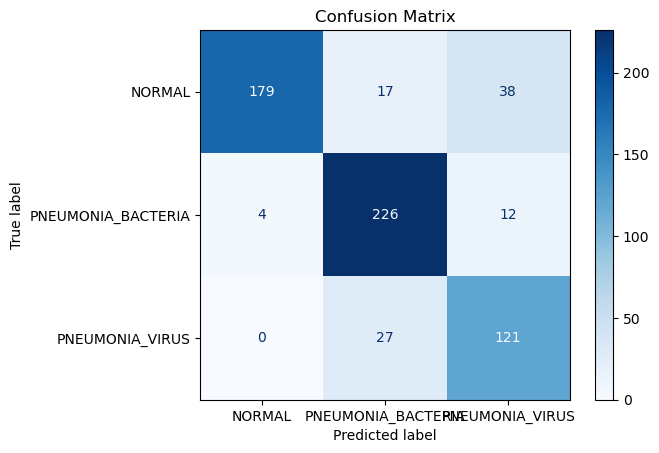

In [9]:
test_model(model)

In [10]:
save_model(model)

Model saved as vgg16_pneumonia_3class.pth
